In [1]:
from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder
from spatial.train import train
from spatial.predict import test

import time
import json
import numpy as np

import torch

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# read in merfish dataset and get columns names
import pandas as pd

# get relevant data stuff
df_file = pd.ExcelFile("~/spatial/data/messi.xlsx")
messi_df = pd.read_excel(df_file, "All.Pairs")
merfish_df = pd.read_csv("~/spatial/data/raw/merfish.csv")
merfish_df = merfish_df.drop(['Blank_1', 'Blank_2', 'Blank_3', 'Blank_4', 'Blank_5', 'Fos'], axis=1)

# these are the 13 ligands or receptors found in MESSI
non_response_genes = ['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 
                      'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt',
                      'Tac2']
# this list stores the control genes aka "Blank_{int}"
blank_genes = []

# we will populate all of the non-response genes as being in one or the other
# the ones already filled in come from the existing 13 L/R genes above
ligands = ["Cbln1", "Cxcl14", "Cbln2", "Vgf", "Scg2", "Cartpt", "Tac2"]
receptors = ["Crhbp", "Gabra1", "Gpr165", "Glra3", "Gabrg1", "Adora2a"]

# ligands and receptor indexes in MERFISH
non_response_indeces = [list(merfish_df.columns).index(gene)-9 for gene in non_response_genes]
ligand_indeces = [list(merfish_df.columns).index(gene)-9 for gene in ligands]
receptor_indeces = [list(merfish_df.columns).index(gene)-9 for gene in receptors]
all_pairs_columns = [
    "Ligand.ApprovedSymbol",
    "Receptor.ApprovedSymbol",
]


# for column name in the column names above
for column in all_pairs_columns:
    for gene in merfish_df.columns:
        if (
            gene.upper() in list(messi_df[column])
            and gene.upper() not in non_response_genes
        ):
            non_response_genes.append(gene)
            non_response_indeces.append(list(merfish_df.columns).index(gene)-9)
            if column[0] == "L":
                ligands.append(gene)
                ligand_indeces.append(list(merfish_df.columns).index(gene)-9)
            else:
                receptors.append(gene)
                receptor_indeces.append(list(merfish_df.columns).index(gene)-9)
        if gene[:5] == "Blank" and gene not in blank_genes:
            blank_genes.append(gene)
            # non_response_indeces.append(list(merfish_df.columns).index(gene)-9)

print(non_response_genes)
print(
    "There are "
    + str(len(non_response_genes))
    + " genes recognized as either ligands or receptors (including new ones)."
)

print(
    "There are "
    + str(len(blank_genes))
    + " blank genes."
)

print(
    "There are "
    + str(155 - len(blank_genes) - len(non_response_genes))
    + " genes that are treated as response variables."
)

print(
    "There are "
    + str(len(ligands))
    + " ligands."
)

print(
    "There are "
    + str(len(receptors))
    + " receptors."
)

response_indeces = list(set(range(155)) - set(non_response_indeces))

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt', 'Tac2', 'Bdnf', 'Bmp7', 'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc', 'Selplg', 'Sema3c', 'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh', 'Gal', 'Gnrh1', 'Nts', 'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3', 'Avpr1a', 'Avpr2', 'Brs3', 'Calcr', 'Cckar', 'Cckbr', 'Crhr1', 'Crhr2', 'Galr1', 'Galr2', 'Grpr', 'Htr2c', 'Igf1r', 'Igf2r', 'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r', 'Npy2r', 'Ntsr1', 'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr', 'Ramp3', 'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr']
There are 71 genes recognized as either ligands or receptors (including new ones).
There are 0 blank genes.
There are 84 genes that are treated as response variables.
There are 31 ligands.
There are 40 receptors.


In [3]:
all(merfish_df.columns[9:][response_indeces] == ['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36', 'Baiap2',
       'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch', 'Col25a1', 'Cplx3',
       'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1', 'Cyp26a1', 'Dgkk', 'Ebf3',
       'Egr2', 'Ermn', 'Esr1', 'Etv1', 'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem',
       'Gjc3', 'Greb1', 'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a',
       'Mki67', 'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nos1', 'Npas1',
       'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x', 'Pgr',
       'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn', 'Serpinb1b', 'Sgk1',
       'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4', 'Sox4', 'Sox6', 'Sox8',
       'Sp9', 'Synpr', 'Syt2', 'Syt4', 'Sytl4', 'Tiparp', 'Tmem108', 'Traf4',
       'Ttn', 'Ttyh2', 'Mbp', 'Nnat', 'Sln', 'Th'])

True

In [4]:
response_indeces

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 10,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 32,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 52,
 53,
 54,
 55,
 58,
 63,
 64,
 66,
 67,
 69,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 85,
 86,
 87,
 88,
 93,
 94,
 96,
 97,
 99,
 102,
 103,
 104,
 106,
 110,
 112,
 113,
 114,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 129,
 130,
 131,
 133,
 134,
 141,
 142,
 147,
 151]

In [5]:
(merfish_df.iloc[:,9:].iloc[:,response_indeces] == 0).mean(axis=1).shape

(1027848,)

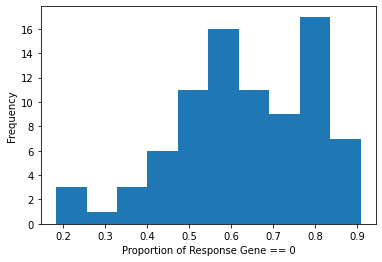

In [6]:
import matplotlib.pyplot as plt

m, n = merfish_df.iloc[:,9:].iloc[:,response_indeces].shape
_ = plt.hist((merfish_df.iloc[:,9:].iloc[:,response_indeces] == 0).mean(axis=0))
_ = plt.xlabel("Proportion of Response Gene == 0")
_ = plt.ylabel("Frequency")

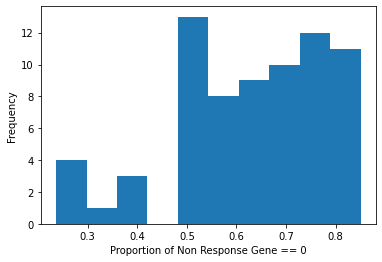

In [7]:
import matplotlib.pyplot as plt

_ = plt.hist((merfish_df.iloc[:,9:].iloc[:,non_response_indeces] == 0).mean(axis=0))
_ = plt.xlabel("Proportion of Non Response Gene == 0")
_ = plt.ylabel("Frequency")

In [8]:
(merfish_df.iloc[:,9:].iloc[:,response_indeces]).mean(axis=0)

Ace2       0.309998
Aldh1l1    3.700103
Amigo2     2.229137
Ano3       0.456953
Aqp4       4.817272
             ...   
Ttyh2      5.574480
Mbp        0.283616
Nnat       0.061053
Sln        0.253654
Th         0.073941
Length: 84, dtype: float64

In [9]:
(merfish_df.iloc[:,9:].iloc[:,non_response_indeces]).mean(axis=0)

Cbln1      1.225062
Cxcl14     3.774559
Crhbp      0.263712
Gabra1     4.476216
Cbln2      6.034579
             ...   
Slc17a7    0.263205
Slc18a2    0.660960
Tacr1      1.283612
Tacr3      1.223262
Trhr       0.496687
Length: 71, dtype: float64

# XGBoost on Whole Data

In [10]:
ligands

['Cbln1',
 'Cxcl14',
 'Cbln2',
 'Vgf',
 'Scg2',
 'Cartpt',
 'Tac2',
 'Bdnf',
 'Bmp7',
 'Cyr61',
 'Fn1',
 'Fst',
 'Gad1',
 'Ntng1',
 'Pnoc',
 'Selplg',
 'Sema3c',
 'Sema4d',
 'Serpine1',
 'Adcyap1',
 'Cck',
 'Crh',
 'Gal',
 'Gnrh1',
 'Nts',
 'Oxt',
 'Penk',
 'Sst',
 'Tac1',
 'Trh',
 'Ucn3']

In [11]:
receptors

['Crhbp',
 'Gabra1',
 'Gpr165',
 'Glra3',
 'Gabrg1',
 'Adora2a',
 'Avpr1a',
 'Avpr2',
 'Brs3',
 'Calcr',
 'Cckar',
 'Cckbr',
 'Crhr1',
 'Crhr2',
 'Galr1',
 'Galr2',
 'Grpr',
 'Htr2c',
 'Igf1r',
 'Igf2r',
 'Kiss1r',
 'Lepr',
 'Lpar1',
 'Mc4r',
 'Npy1r',
 'Npy2r',
 'Ntsr1',
 'Oprd1',
 'Oprk1',
 'Oprl1',
 'Oxtr',
 'Pdgfra',
 'Prlr',
 'Ramp3',
 'Rxfp1',
 'Slc17a7',
 'Slc18a2',
 'Tacr1',
 'Tacr3',
 'Trhr']

In [12]:
merfish_df.columns[9:]

Index(['Ace2', 'Adora2a', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar',
       'Arhgap36', 'Avpr1a', 'Avpr2',
       ...
       'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
       'Vgf'],
      dtype='object', length=155)

In [13]:
merfish_df.columns[9:][non_response_indeces]

Index(['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 'Glra3',
       'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt', 'Tac2', 'Bdnf', 'Bmp7',
       'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc', 'Selplg', 'Sema3c',
       'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh', 'Gal', 'Gnrh1', 'Nts',
       'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3', 'Avpr1a', 'Avpr2', 'Brs3',
       'Calcr', 'Cckar', 'Cckbr', 'Crhr1', 'Crhr2', 'Galr1', 'Galr2', 'Grpr',
       'Htr2c', 'Igf1r', 'Igf2r', 'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r',
       'Npy2r', 'Ntsr1', 'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr',
       'Ramp3', 'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr'],
      dtype='object')

In [14]:
response_indeces, ligand_indeces, receptor_indeces
assert set(response_indeces) & set(ligand_indeces) == set()
assert set(response_indeces) & set(receptor_indeces) == set()
assert set(ligand_indeces) & set(receptor_indeces) == set()

In [15]:
with open('../spatial/non_response_blank_removed.txt', "r", encoding="utf8") as genes_file:
    features = [int(x) for x in genes_file.read().split(",")]
    genes_file.close()

In [7]:
def get_neighbors(batch_obj):
    return [batch_obj.edge_index[:, batch_obj.edge_index[0] == i][1] for i in range(batch_obj.x.shape[0])]

In [8]:
def get_ligand_sum(data, neighbors_tensor, ligand_indeces):
    return torch.tensor([np.array(data.index_select(0, neighbors).index_select(1, torch.tensor(ligand_indeces))) for neighbors in neighbors_tensor]).sum(axis=1)

In [9]:
import torch.nn.functional as F

def get_celltypes(cell_behavior_tensor, neighbors_tensor):
    # print(f"There are {(num_classes := cell_behavior_tensor.max() + 1)} different cell types.")
    return [F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes) for neighbors in neighbors_tensor] 

In [10]:
def get_celltype_simplex(cell_behavior_tensor, neighbors_tensor):
    print(f"There are {(num_classes := 16)} different cell types.")
    return torch.cat([(torch.mean(1.0*F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes), dim=0)).unsqueeze(0) for neighbors in neighbors_tensor], dim=0)

In [11]:
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

In [29]:
trial_run = MerfishDataset('../data')

In [30]:
datalist = trial_run.construct_graphs(3, True)

In [47]:
scores_list = []

start = time.time()

train_dataset = None

for batch in datalist:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)
    
    # behavior and cell_type
    behavior_and_cell_type = batch.y
    
    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)
    
    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)
    
    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)
    
    # combine all the data
    X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
    scaler = StandardScaler().fit(X)
    X = torch.tensor(scaler.transform(X))
    
    if train_dataset is None:
        train_dataset = X
        train_Y = x[:, 151]
    else:
        train_dataset = torch.cat((train_dataset, X), dim=0)
        train_Y = torch.cat((train_Y, x[:, 151]), dim=0)
        
    print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")

There are 16 different cell types.
Batch: 1/600
There are 16 different cell types.
Batch: 2/600
There are 16 different cell types.
Batch: 3/600
There are 16 different cell types.
Batch: 4/600
There are 16 different cell types.
Batch: 5/600
There are 16 different cell types.
Batch: 6/600
There are 16 different cell types.
Batch: 7/600
There are 16 different cell types.
Batch: 8/600
There are 16 different cell types.
Batch: 9/600
There are 16 different cell types.
Batch: 10/600
There are 16 different cell types.
Batch: 11/600
There are 16 different cell types.
Batch: 12/600
There are 16 different cell types.
Batch: 13/600
There are 16 different cell types.
Batch: 14/600
There are 16 different cell types.
Batch: 15/600
There are 16 different cell types.
Batch: 16/600
There are 16 different cell types.
Batch: 17/600
There are 16 different cell types.
Batch: 18/600
There are 16 different cell types.
Batch: 19/600
There are 16 different cell types.
Batch: 20/600
There are 16 different cell t

Batch: 167/600
There are 16 different cell types.
Batch: 168/600
There are 16 different cell types.
Batch: 169/600
There are 16 different cell types.
Batch: 170/600
There are 16 different cell types.
Batch: 171/600
There are 16 different cell types.
Batch: 172/600
There are 16 different cell types.
Batch: 173/600
There are 16 different cell types.
Batch: 174/600
There are 16 different cell types.
Batch: 175/600
There are 16 different cell types.
Batch: 176/600
There are 16 different cell types.
Batch: 177/600
There are 16 different cell types.
Batch: 178/600
There are 16 different cell types.
Batch: 179/600
There are 16 different cell types.
Batch: 180/600
There are 16 different cell types.
Batch: 181/600
There are 16 different cell types.
Batch: 182/600
There are 16 different cell types.
Batch: 183/600
There are 16 different cell types.
Batch: 184/600
There are 16 different cell types.
Batch: 185/600
There are 16 different cell types.
Batch: 186/600
There are 16 different cell types.


Batch: 331/600
There are 16 different cell types.
Batch: 332/600
There are 16 different cell types.
Batch: 333/600
There are 16 different cell types.
Batch: 334/600
There are 16 different cell types.
Batch: 335/600
There are 16 different cell types.
Batch: 336/600
There are 16 different cell types.
Batch: 337/600
There are 16 different cell types.
Batch: 338/600
There are 16 different cell types.
Batch: 339/600
There are 16 different cell types.
Batch: 340/600
There are 16 different cell types.
Batch: 341/600
There are 16 different cell types.
Batch: 342/600
There are 16 different cell types.
Batch: 343/600
There are 16 different cell types.
Batch: 344/600
There are 16 different cell types.
Batch: 345/600
There are 16 different cell types.
Batch: 346/600
There are 16 different cell types.
Batch: 347/600
There are 16 different cell types.
Batch: 348/600
There are 16 different cell types.
Batch: 349/600
There are 16 different cell types.
Batch: 350/600
There are 16 different cell types.


Batch: 495/600
There are 16 different cell types.
Batch: 496/600
There are 16 different cell types.
Batch: 497/600
There are 16 different cell types.
Batch: 498/600
There are 16 different cell types.
Batch: 499/600
There are 16 different cell types.
Batch: 500/600
There are 16 different cell types.
Batch: 501/600
There are 16 different cell types.
Batch: 502/600
There are 16 different cell types.
Batch: 503/600
There are 16 different cell types.
Batch: 504/600
There are 16 different cell types.
Batch: 505/600
There are 16 different cell types.
Batch: 506/600
There are 16 different cell types.
Batch: 507/600
There are 16 different cell types.
Batch: 508/600
There are 16 different cell types.
Batch: 509/600
There are 16 different cell types.
Batch: 510/600
There are 16 different cell types.
Batch: 511/600
There are 16 different cell types.
Batch: 512/600
There are 16 different cell types.
Batch: 513/600
There are 16 different cell types.
Batch: 514/600
There are 16 different cell types.


In [48]:
assert train_dataset.shape[0] == train_Y.shape[0]

test_datalist = trial_run.construct_graphs(3, False)

scores_list = []

test_dataset = None

for batch in test_datalist:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)
    
    # behavior and cell_type
    behavior_and_cell_type = batch.y
    
    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)
    
    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)
    
    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)
    
    # combine all the data
    test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
    
    # standardize the data using TRAINING mean and sd.
    test_X = torch.tensor(scaler.transform(test_X))
    
    if test_dataset is None:
        test_dataset = test_X
        test_Y = x[:, 151]
        print(test_dataset.shape[0], test_Y.shape[0])
    else:
        test_dataset = torch.cat((test_dataset, test_X), dim=0)
        test_Y = torch.cat((test_Y, x[:, 151]), dim=0)
        
    print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

There are 16 different cell types.
1454 1454
Batch: 1/124
There are 16 different cell types.
Batch: 2/124
There are 16 different cell types.
Batch: 3/124
There are 16 different cell types.
Batch: 4/124
There are 16 different cell types.
Batch: 5/124
There are 16 different cell types.
Batch: 6/124
There are 16 different cell types.
Batch: 7/124
There are 16 different cell types.
Batch: 8/124
There are 16 different cell types.
Batch: 9/124
There are 16 different cell types.
Batch: 10/124
There are 16 different cell types.
Batch: 11/124
There are 16 different cell types.
Batch: 12/124
There are 16 different cell types.
Batch: 13/124
There are 16 different cell types.
Batch: 14/124
There are 16 different cell types.
Batch: 15/124
There are 16 different cell types.
Batch: 16/124
There are 16 different cell types.
Batch: 17/124
There are 16 different cell types.
Batch: 18/124
There are 16 different cell types.
Batch: 19/124
There are 16 different cell types.
Batch: 20/124
There are 16 differ

In [49]:
assert test_dataset.shape[0] == test_Y.shape[0]

In [50]:
model_list = []
MAE_list = []

# for each response gene in our response matrix....

if len(train_Y.shape) == 1:
    train_Y = train_Y.reshape(-1,1)
    test_Y = test_Y.reshape(-1,1)
    
for i in range(train_Y.shape[1]):
    
    print(i)
    # create response gene variables
    y_i_train = train_Y[:, i]
    y_i_test = test_Y[:, i]
    
    # create XGBoost Regression Model
    model = xgb.XGBRegressor(tree_method="approx", nthread=1)

    # fit the regression model and add it to model list
    # print(train_dataset.shape, y_i_train.shape)
    model.fit(np.array(train_dataset), np.array(y_i_train))
    model_list.append((f"Gene {i}", model_list))

    # run the testing data through the model
    test_output = torch.tensor(model.predict(np.array(test_dataset)))
    
    # collect its MAE
    MAE_list.append(F.l1_loss(test_output, y_i_test))
    print(MAE_list[-1])
    
    print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

end = time.time()
print(end-start)

0
tensor(0.0610)
Response Gene: 1/1
1139.3944375514984


In [51]:
MAE_list

[tensor(0.0610)]

In [ ]:
train_dataset.shape

In [47]:
test_dataset.shape

torch.Size([73655, 121])

In [52]:
np.array(MAE_list).mean()

0.23543492

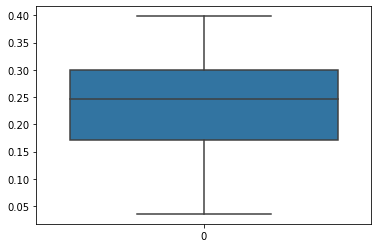

In [67]:
import seaborn as sns

ax = sns.boxplot(data=np.array(MAE_list).reshape(1,-1))

# XGBoost on Excitatory Cells from Female Naive Only

In [4]:
behaviors = ["Naive"]
sexes = ["Female"]

In [5]:
with open('animal_id.json') as json_file:
    animals = json.load(json_file)

In [16]:
# loss_dict = {}
time_dict = {}
loss_excitatory_dict = {}
# loss_inhibitory_dict = {}
gene_loss_dict = {}

for behavior in behaviors:
    for sex in sexes:
        try:
            animal_list = animals[behavior][sex]
        except KeyError:
            continue
        behavior = [behavior]
        sex = [sex]
        # print(behavior, sex, animal_list)
        for animal in animal_list:
            start = time.time()
            trial_run = FilteredMerfishDataset('data', sexes=sex, behaviors=behavior, test_animal=animal)
            print(sex, behavior, animal)
            datalist = trial_run.construct_graphs(3, True)
            print(len(datalist))
            start = time.time()

            train_dataset = None

            for batch in datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
                excitatory_cells = (behavior_and_cell_type[:, 1] == 6).nonzero(as_tuple=True)[0]
                X = torch.index_select(X, 0, excitatory_cells)
#                 scaler = StandardScaler().fit(X)
#                 X = torch.tensor(scaler.transform(X))

                if train_dataset is None:
                    train_dataset = X
                    train_Y = torch.index_select(x[:, response_indeces], 0, excitatory_cells)
                else:
                    train_dataset = torch.cat((train_dataset, X), dim=0)
                    train_Y = torch.cat((train_Y, torch.index_select(x[:, response_indeces], 0, excitatory_cells)), dim=0)

                print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")
                
            scaler = StandardScaler().fit(train_dataset)
            train_dataset = torch.tensor(scaler.transform(train_dataset))

            assert train_dataset.shape[0] == train_Y.shape[0]

            test_datalist = trial_run.construct_graphs(3, False)

            test_dataset = None

            for batch in test_datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)

                # standardize the data using TRAINING mean and sd.
                excitatory_cells = (behavior_and_cell_type[:, 1] == 6).nonzero(as_tuple=True)[0]
                test_X = torch.index_select(test_X, 0, excitatory_cells)
#                 test_X = torch.tensor(scaler.transform(test_X))

                if test_dataset is None:
                    test_dataset = test_X
                    test_Y = torch.index_select(x[:, response_indeces], 0, excitatory_cells)
                    print(test_dataset.shape[0], test_Y.shape[0])
                else:
                    test_dataset = torch.cat((test_dataset, test_X), dim=0)
                    test_Y = torch.cat((test_Y, torch.index_select(x[:, response_indeces], 0, excitatory_cells)), dim=0)

                print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

            test_dataset = torch.tensor(scaler.transform(test_dataset))
            
            assert test_dataset.shape[0] == test_Y.shape[0]

            model_list = []
            MAE_list = []

            # for each response gene in our response matrix....
            for i in range(train_Y.shape[1]):

                # create response gene variables
                y_i_train = train_Y[:, i]
                y_i_test = test_Y[:, i]
                
                if i == 0 and behavior == ["Naive"] and animal == 1:
                    print(f"trainY Mean: {torch.mean(y_i_train)}")
                    print(f"testY Mean: {torch.mean(y_i_test)}")

                # create XGBoost Regression Model
                model = xgb.XGBRegressor(tree_method="gpu_hist", nthread=1, objective="reg:squarederror", eval_metric="mae")

                # fit the regression model and add it to model list
                # print(train_dataset.shape, y_i_train.shape)
                model.fit(np.array(train_dataset), np.array(y_i_train))
                model_list.append((f"Gene {i}", model_list))

                # run the testing data through the model
                test_output = torch.tensor(model.predict(np.array(test_dataset)))

                # collect its MAE
                MAE_list.append(F.l1_loss(test_output, y_i_test))
                print(MAE_list[-1])
                print(f"Response Gene {merfish_df.columns[9:][response_indeces[i]]} MAE: {MAE_list[-1].item()}")
                gene_loss_dict[merfish_df.columns[9:][response_indeces[i]]] = MAE_list[-1].item()
                print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

            end = time.time()
            time_dict[f"{sex}_{behavior}_{animal}"] = end-start
            loss_excitatory_dict[f"{sex}_{behavior}_{animal}"] = float(np.mean(MAE_list))

            with open("XGBoost_time_excitatory.json", "w") as outfile:
                json.dump(time_dict, outfile, indent=4)

            with open("XGBoost_MAE_excitatory.json", "w") as outfile:
                json.dump(loss_excitatory_dict, outfile, indent=4)

            print(f"Test animal {animal} CV finished!")

data/raw/merfish_messi.hdf5
['Female'] ['Naive'] 1
data/raw/merfish_messi.hdf5
23
There are 16 different cell types.
Batch: 1/23
There are 16 different cell types.
Batch: 2/23
There are 16 different cell types.
Batch: 3/23
There are 16 different cell types.
Batch: 4/23
There are 16 different cell types.
Batch: 5/23
There are 16 different cell types.
Batch: 6/23
There are 16 different cell types.
Batch: 7/23
There are 16 different cell types.
Batch: 8/23
There are 16 different cell types.
Batch: 9/23
There are 16 different cell types.
Batch: 10/23
There are 16 different cell types.
Batch: 11/23
There are 16 different cell types.
Batch: 12/23
There are 16 different cell types.
Batch: 13/23
There are 16 different cell types.
Batch: 14/23
There are 16 different cell types.
Batch: 15/23
There are 16 different cell types.
Batch: 16/23
There are 16 different cell types.
Batch: 17/23
There are 16 different cell types.
Batch: 18/23
There are 16 different cell types.
Batch: 19/23
There are 16 di

tensor(0.0339)
Response Gene Mbp MAE: 0.033856336027383804
Response Gene: 81/84
tensor(0.0432)
Response Gene Nnat MAE: 0.043216269463300705
Response Gene: 82/84
tensor(0.1739)
Response Gene Sln MAE: 0.17394068837165833
Response Gene: 83/84
tensor(0.0559)
Response Gene Th MAE: 0.05593801289796829
Response Gene: 84/84
Test animal 1 CV finished!
data/raw/merfish_messi.hdf5
['Female'] ['Naive'] 2
data/raw/merfish_messi.hdf5
23
There are 16 different cell types.
Batch: 1/23
There are 16 different cell types.
Batch: 2/23
There are 16 different cell types.
Batch: 3/23
There are 16 different cell types.
Batch: 4/23
There are 16 different cell types.
Batch: 5/23
There are 16 different cell types.
Batch: 6/23
There are 16 different cell types.
Batch: 7/23
There are 16 different cell types.
Batch: 8/23
There are 16 different cell types.
Batch: 9/23
There are 16 different cell types.
Batch: 10/23
There are 16 different cell types.
Batch: 11/23
There are 16 different cell types.
Batch: 12/23
There 

tensor(0.5087)
Response Gene Tmem108 MAE: 0.5086565017700195
Response Gene: 77/84
tensor(0.4316)
Response Gene Traf4 MAE: 0.43157079815864563
Response Gene: 78/84
tensor(0.2184)
Response Gene Ttn MAE: 0.21839368343353271
Response Gene: 79/84
tensor(0.3420)
Response Gene Ttyh2 MAE: 0.3419814109802246
Response Gene: 80/84
tensor(0.0319)
Response Gene Mbp MAE: 0.03193281963467598
Response Gene: 81/84
tensor(0.0422)
Response Gene Nnat MAE: 0.042202454060316086
Response Gene: 82/84
tensor(0.1482)
Response Gene Sln MAE: 0.14824578166007996
Response Gene: 83/84
tensor(0.0603)
Response Gene Th MAE: 0.060302603989839554
Response Gene: 84/84
Test animal 2 CV finished!
data/raw/merfish_messi.hdf5
['Female'] ['Naive'] 3
data/raw/merfish_messi.hdf5
29
There are 16 different cell types.
Batch: 1/29
There are 16 different cell types.
Batch: 2/29
There are 16 different cell types.
Batch: 3/29
There are 16 different cell types.
Batch: 4/29
There are 16 different cell types.
Batch: 5/29
There are 16 dif

tensor(0.4438)
Response Gene Syt2 MAE: 0.44383034110069275
Response Gene: 73/84
tensor(0.4410)
Response Gene Syt4 MAE: 0.44098997116088867
Response Gene: 74/84
tensor(0.3611)
Response Gene Sytl4 MAE: 0.3610665500164032
Response Gene: 75/84
tensor(0.4213)
Response Gene Tiparp MAE: 0.4213055670261383
Response Gene: 76/84
tensor(0.5006)
Response Gene Tmem108 MAE: 0.5005584955215454
Response Gene: 77/84
tensor(0.4122)
Response Gene Traf4 MAE: 0.4122086763381958
Response Gene: 78/84
tensor(0.2295)
Response Gene Ttn MAE: 0.2295016646385193
Response Gene: 79/84
tensor(0.3674)
Response Gene Ttyh2 MAE: 0.3674437701702118
Response Gene: 80/84
tensor(0.0313)
Response Gene Mbp MAE: 0.031252481043338776
Response Gene: 81/84
tensor(0.0455)
Response Gene Nnat MAE: 0.045471690595149994
Response Gene: 82/84
tensor(0.3184)
Response Gene Sln MAE: 0.31844013929367065
Response Gene: 83/84
tensor(0.0453)
Response Gene Th MAE: 0.04525744169950485
Response Gene: 84/84
Test animal 3 CV finished!
data/raw/merfi

tensor(0.3239)
Response Gene Sox6 MAE: 0.32392197847366333
Response Gene: 69/84
tensor(0.4115)
Response Gene Sox8 MAE: 0.4114803373813629
Response Gene: 70/84
tensor(0.2672)
Response Gene Sp9 MAE: 0.26720255613327026
Response Gene: 71/84
tensor(0.4133)
Response Gene Synpr MAE: 0.4132850766181946
Response Gene: 72/84
tensor(0.4017)
Response Gene Syt2 MAE: 0.401699036359787
Response Gene: 73/84
tensor(0.5005)
Response Gene Syt4 MAE: 0.5004578232765198
Response Gene: 74/84
tensor(0.3680)
Response Gene Sytl4 MAE: 0.36795148253440857
Response Gene: 75/84
tensor(0.4348)
Response Gene Tiparp MAE: 0.43483996391296387
Response Gene: 76/84
tensor(0.5192)
Response Gene Tmem108 MAE: 0.5192211270332336
Response Gene: 77/84
tensor(0.4207)
Response Gene Traf4 MAE: 0.4206959307193756
Response Gene: 78/84
tensor(0.2150)
Response Gene Ttn MAE: 0.2150038182735443
Response Gene: 79/84
tensor(0.3573)
Response Gene Ttyh2 MAE: 0.35728394985198975
Response Gene: 80/84
tensor(0.0408)
Response Gene Mbp MAE: 0.0

tensor(0.6640)
Response Gene Syt4 MAE: 0.6639531254768372
Response Gene: 74/84
tensor(0.4519)
Response Gene Sytl4 MAE: 0.45188215374946594
Response Gene: 75/84
tensor(0.5569)
Response Gene Tiparp MAE: 0.5568714141845703
Response Gene: 76/84
tensor(0.5894)
Response Gene Tmem108 MAE: 0.5893596410751343
Response Gene: 77/84
tensor(0.4334)
Response Gene Traf4 MAE: 0.433431476354599
Response Gene: 78/84
tensor(0.2953)
Response Gene Ttn MAE: 0.2952735126018524
Response Gene: 79/84
tensor(0.4670)
Response Gene Ttyh2 MAE: 0.4670071005821228
Response Gene: 80/84
tensor(0.0507)
Response Gene Mbp MAE: 0.050671014934778214
Response Gene: 81/84
tensor(0.0730)
Response Gene Nnat MAE: 0.07296404242515564
Response Gene: 82/84
tensor(0.1562)
Response Gene Sln MAE: 0.15620915591716766
Response Gene: 83/84
tensor(0.0438)
Response Gene Th MAE: 0.043810322880744934
Response Gene: 84/84
Test animal 20 CV finished!
data/raw/merfish_messi.hdf5
['Female'] ['Virgin Parenting'] 21
data/raw/merfish_messi.hdf5
16


tensor(0.3122)
Response Gene Ttn MAE: 0.3122228682041168
Response Gene: 79/84
tensor(0.4453)
Response Gene Ttyh2 MAE: 0.4452976882457733
Response Gene: 80/84
tensor(0.0373)
Response Gene Mbp MAE: 0.037267621606588364
Response Gene: 81/84
tensor(0.0590)
Response Gene Nnat MAE: 0.05899619311094284
Response Gene: 82/84
tensor(0.1596)
Response Gene Sln MAE: 0.15960323810577393
Response Gene: 83/84
tensor(0.0447)
Response Gene Th MAE: 0.04470496252179146
Response Gene: 84/84
Test animal 21 CV finished!
data/raw/merfish_messi.hdf5
['Female'] ['Virgin Parenting'] 22
data/raw/merfish_messi.hdf5
16
There are 16 different cell types.
Batch: 1/16
There are 16 different cell types.
Batch: 2/16
There are 16 different cell types.
Batch: 3/16
There are 16 different cell types.
Batch: 4/16
There are 16 different cell types.
Batch: 5/16
There are 16 different cell types.
Batch: 6/16
There are 16 different cell types.
Batch: 7/16
There are 16 different cell types.
Batch: 8/16
There are 16 different cell

tensor(0.0387)
Response Gene Th MAE: 0.03871939703822136
Response Gene: 84/84
Test animal 22 CV finished!
data/raw/merfish_messi.hdf5
['Female'] ['Virgin Parenting'] 23
data/raw/merfish_messi.hdf5
16
There are 16 different cell types.
Batch: 1/16
There are 16 different cell types.
Batch: 2/16
There are 16 different cell types.
Batch: 3/16
There are 16 different cell types.
Batch: 4/16
There are 16 different cell types.
Batch: 5/16
There are 16 different cell types.
Batch: 6/16
There are 16 different cell types.
Batch: 7/16
There are 16 different cell types.
Batch: 8/16
There are 16 different cell types.
Batch: 9/16
There are 16 different cell types.
Batch: 10/16
There are 16 different cell types.
Batch: 11/16
There are 16 different cell types.
Batch: 12/16
There are 16 different cell types.
Batch: 13/16
There are 16 different cell types.
Batch: 14/16
There are 16 different cell types.
Batch: 15/16
There are 16 different cell types.
Batch: 16/16
data/raw/merfish_messi.hdf5
There are 16 

There are 16 different cell types.
Batch: 5/16
There are 16 different cell types.
Batch: 6/16
There are 16 different cell types.
Batch: 7/16
There are 16 different cell types.
Batch: 8/16
There are 16 different cell types.
Batch: 9/16
There are 16 different cell types.
Batch: 10/16
There are 16 different cell types.
Batch: 11/16
There are 16 different cell types.
Batch: 12/16
There are 16 different cell types.
Batch: 13/16
There are 16 different cell types.
Batch: 14/16
There are 16 different cell types.
Batch: 15/16
There are 16 different cell types.
Batch: 16/16
data/raw/merfish_messi.hdf5
There are 16 different cell types.
985 985
Batch: 1/4
There are 16 different cell types.
Batch: 2/4
There are 16 different cell types.
Batch: 3/4
There are 16 different cell types.
Batch: 4/4
tensor(0.2851)
Response Gene Ace2 MAE: 0.28508642315864563
Response Gene: 1/84
tensor(0.6243)
Response Gene Aldh1l1 MAE: 0.6243247389793396
Response Gene: 2/84
tensor(0.6314)
Response Gene Amigo2 MAE: 0.631419

There are 16 different cell types.
667 667
Batch: 1/4
There are 16 different cell types.
Batch: 2/4
There are 16 different cell types.
Batch: 3/4
There are 16 different cell types.
Batch: 4/4
tensor(0.3235)
Response Gene Ace2 MAE: 0.3234545886516571
Response Gene: 1/84
tensor(0.6443)
Response Gene Aldh1l1 MAE: 0.6442933678627014
Response Gene: 2/84
tensor(0.7015)
Response Gene Amigo2 MAE: 0.7015389204025269
Response Gene: 3/84
tensor(0.3946)
Response Gene Ano3 MAE: 0.39457497000694275
Response Gene: 4/84
tensor(0.6271)
Response Gene Aqp4 MAE: 0.627106785774231
Response Gene: 5/84
tensor(0.7378)
Response Gene Ar MAE: 0.7377594113349915
Response Gene: 6/84
tensor(0.7663)
Response Gene Arhgap36 MAE: 0.7663161158561707
Response Gene: 7/84
tensor(0.5620)
Response Gene Baiap2 MAE: 0.5619590282440186
Response Gene: 8/84
tensor(0.5942)
Response Gene Ccnd2 MAE: 0.594208836555481
Response Gene: 9/84
tensor(0.6715)
Response Gene Cd24a MAE: 0.6714621186256409
Response Gene: 10/84
tensor(0.4593)
Re

tensor(0.6839)
Response Gene Ar MAE: 0.6838722825050354
Response Gene: 6/84
tensor(0.6509)
Response Gene Arhgap36 MAE: 0.65093994140625
Response Gene: 7/84
tensor(0.5030)
Response Gene Baiap2 MAE: 0.5029855966567993
Response Gene: 8/84
tensor(0.5498)
Response Gene Ccnd2 MAE: 0.5498313903808594
Response Gene: 9/84
tensor(0.5994)
Response Gene Cd24a MAE: 0.59937584400177
Response Gene: 10/84
tensor(0.3950)
Response Gene Cdkn1a MAE: 0.39499810338020325
Response Gene: 11/84
tensor(0.4183)
Response Gene Cenpe MAE: 0.41827863454818726
Response Gene: 12/84
tensor(0.3165)
Response Gene Chat MAE: 0.31654876470565796
Response Gene: 13/84
tensor(0.3682)
Response Gene Coch MAE: 0.36816972494125366
Response Gene: 14/84
tensor(0.5502)
Response Gene Col25a1 MAE: 0.5501906871795654
Response Gene: 15/84
tensor(0.3362)
Response Gene Cplx3 MAE: 0.3361516296863556
Response Gene: 16/84
tensor(0.4958)
Response Gene Cpne5 MAE: 0.4957575500011444
Response Gene: 17/84
tensor(0.5517)
Response Gene Creb3l1 MAE: 

tensor(0.3998)
Response Gene Coch MAE: 0.39981889724731445
Response Gene: 14/84
tensor(0.5652)
Response Gene Col25a1 MAE: 0.5652340650558472
Response Gene: 15/84
tensor(0.3645)
Response Gene Cplx3 MAE: 0.3645295202732086
Response Gene: 16/84
tensor(0.5291)
Response Gene Cpne5 MAE: 0.529114842414856
Response Gene: 17/84
tensor(0.5833)
Response Gene Creb3l1 MAE: 0.5832688212394714
Response Gene: 18/84
tensor(0.5468)
Response Gene Cspg5 MAE: 0.5467669367790222
Response Gene: 19/84
tensor(0.3650)
Response Gene Cyp19a1 MAE: 0.3650115430355072
Response Gene: 20/84
tensor(0.2216)
Response Gene Cyp26a1 MAE: 0.22164686024188995
Response Gene: 21/84
tensor(0.6902)
Response Gene Dgkk MAE: 0.6902128458023071
Response Gene: 22/84
tensor(0.4045)
Response Gene Ebf3 MAE: 0.40453076362609863
Response Gene: 23/84
tensor(0.3408)
Response Gene Egr2 MAE: 0.34080880880355835
Response Gene: 24/84
tensor(0.5156)
Response Gene Ermn MAE: 0.5156410336494446
Response Gene: 25/84
tensor(0.4627)
Response Gene Esr1 

tensor(0.7783)
Response Gene Dgkk MAE: 0.7783000469207764
Response Gene: 22/84
tensor(0.4218)
Response Gene Ebf3 MAE: 0.421772301197052
Response Gene: 23/84
tensor(0.3768)
Response Gene Egr2 MAE: 0.3768244981765747
Response Gene: 24/84
tensor(0.5444)
Response Gene Ermn MAE: 0.5443748235702515
Response Gene: 25/84
tensor(0.5437)
Response Gene Esr1 MAE: 0.5436842441558838
Response Gene: 26/84
tensor(0.5371)
Response Gene Etv1 MAE: 0.5371435880661011
Response Gene: 27/84
tensor(0.3372)
Response Gene Fbxw13 MAE: 0.3372476398944855
Response Gene: 28/84
tensor(0.6169)
Response Gene Fezf1 MAE: 0.6168707609176636
Response Gene: 29/84
tensor(0.2648)
Response Gene Gbx2 MAE: 0.26480862498283386
Response Gene: 30/84
tensor(0.7315)
Response Gene Gda MAE: 0.7315312623977661
Response Gene: 31/84
tensor(0.4565)
Response Gene Gem MAE: 0.4564806818962097
Response Gene: 32/84
tensor(0.5833)
Response Gene Gjc3 MAE: 0.5832584500312805
Response Gene: 33/84
tensor(0.3803)
Response Gene Greb1 MAE: 0.380334496

In [17]:
gene_loss_dict

{'Ace2': 0.3591974973678589,
 'Aldh1l1': 0.6782089471817017,
 'Amigo2': 0.6528394818305969,
 'Ano3': 0.43795013427734375,
 'Aqp4': 0.7277629375457764,
 'Ar': 0.7990132570266724,
 'Arhgap36': 0.7744676470756531,
 'Baiap2': 0.5581461787223816,
 'Ccnd2': 0.6641496419906616,
 'Cd24a': 0.6878949999809265,
 'Cdkn1a': 0.45861583948135376,
 'Cenpe': 0.5149195790290833,
 'Chat': 0.41821032762527466,
 'Coch': 0.4402632415294647,
 'Col25a1': 0.6198657751083374,
 'Cplx3': 0.41473716497421265,
 'Cpne5': 0.5807797908782959,
 'Creb3l1': 0.6683189272880554,
 'Cspg5': 0.6448946595191956,
 'Cyp19a1': 0.4262200891971588,
 'Cyp26a1': 0.24991248548030853,
 'Dgkk': 0.7783000469207764,
 'Ebf3': 0.421772301197052,
 'Egr2': 0.3768244981765747,
 'Ermn': 0.5443748235702515,
 'Esr1': 0.5436842441558838,
 'Etv1': 0.5371435880661011,
 'Fbxw13': 0.3372476398944855,
 'Fezf1': 0.6168707609176636,
 'Gbx2': 0.26480862498283386,
 'Gda': 0.7315312623977661,
 'Gem': 0.4564806818962097,
 'Gjc3': 0.5832584500312805,
 'Greb1'

In [75]:
assert list(merfish_df.columns[9:]).index("Ace2") == 0

# XGBoost on All Cells from Female Naive Only

In [10]:
behaviors = ["Naive"]
sexes = ["Female"]

In [11]:
with open('animal_id.json') as json_file:
    animals = json.load(json_file)

In [16]:
# loss_dict = {}
time_dict = {}
loss_dict = {}
# loss_inhibitory_dict = {}
gene_loss_dict = {}

for behavior in behaviors:
    for sex in sexes:
        try:
            animal_list = animals[behavior][sex]
        except KeyError:
            continue
        behavior = [behavior]
        sex = [sex]
        # print(behavior, sex, animal_list)
        for animal in animal_list:
            start = time.time()
            trial_run = FilteredMerfishDataset('data', sexes=sex, behaviors=behavior, test_animal=animal)
            print(sex, behavior, animal)
            datalist = trial_run.construct_graphs(3, True)
            print(len(datalist))
            start = time.time()

            train_dataset = None

            for batch in datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
#                 scaler = StandardScaler().fit(X)
#                 X = torch.tensor(scaler.transform(X))

                if train_dataset is None:
                    train_dataset = X
                    train_Y = x[:, response_indeces]
                else:
                    train_dataset = torch.cat((train_dataset, X), dim=0)
                    train_Y = torch.cat((train_Y, x[:, response_indeces]), dim=0)

                print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")
                
            scaler = StandardScaler().fit(train_dataset)
            train_dataset = torch.tensor(scaler.transform(train_dataset))

            assert train_dataset.shape[0] == train_Y.shape[0]

            test_datalist = trial_run.construct_graphs(3, False)

            test_dataset = None

            for batch in test_datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)

                # standardize the data using TRAINING mean and sd.
                test_X = torch.tensor(scaler.transform(test_X))

                if test_dataset is None:
                    test_dataset = test_X
                    test_Y = x[:, response_indeces]
                    print(test_dataset.shape[0], test_Y.shape[0])
                else:
                    test_dataset = torch.cat((test_dataset, test_X), dim=0)
                    test_Y = torch.cat((test_Y, x[:, response_indeces]), dim=0)

                print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

            test_dataset = torch.tensor(scaler.transform(test_dataset))
            
            assert test_dataset.shape[0] == test_Y.shape[0]

            model_list = []
            MAE_list = []

            # for each response gene in our response matrix....
            for i in range(train_Y.shape[1]):
                print(train_dataset.shape)

                # create response gene variables
                y_i_train = train_Y[:, i]
                y_i_test = test_Y[:, i]
                
                if i == 0 and behavior == ["Naive"] and animal == 1:
                    print(f"trainY Mean: {torch.mean(y_i_train)}")
                    print(f"testY Mean: {torch.mean(y_i_test)}")

                # create XGBoost Regression Model
                model = xgb.XGBRegressor(tree_method="gpu_hist", nthread=1, objective="reg:squarederror", eval_metric="mae")

                # fit the regression model and add it to model list
                # print(train_dataset.shape, y_i_train.shape)
                model.fit(np.array(train_dataset), np.array(y_i_train))
                model_list.append((f"Gene {i}", model_list))

                # run the testing data through the model
                test_output = torch.tensor(model.predict(np.array(test_dataset)))

                # collect its MAE
                MAE_list.append(F.l1_loss(test_output, y_i_test))
                print(MAE_list[-1])
                print(f"Response Gene {merfish_df.columns[9:][response_indeces[i]]} MAE: {MAE_list[-1].item()}")
                gene_loss_dict[merfish_df.columns[9:][response_indeces[i]]] = MAE_list[-1].item()
                print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

            end = time.time()
            time_dict[f"{sex}_{behavior}_{animal}"] = end-start
            loss_dict[f"{sex}_{behavior}_{animal}"] = float(np.mean(MAE_list))

            with open("XGBoost_time_all.json", "w") as outfile:
                json.dump(time_dict, outfile, indent=4)

            with open("XGBoost_MAE.json", "w") as outfile:
                json.dump(loss_dict, outfile, indent=4)

            print(f"Test animal {animal} CV finished!")

data/raw/merfish_messi.hdf5
['Female'] ['Naive'] 1
data/raw/merfish_messi.hdf5
23
There are 16 different cell types.
Batch: 1/23
There are 16 different cell types.
Batch: 2/23
There are 16 different cell types.
Batch: 3/23
There are 16 different cell types.
Batch: 4/23
There are 16 different cell types.
Batch: 5/23
There are 16 different cell types.
Batch: 6/23
There are 16 different cell types.
Batch: 7/23
There are 16 different cell types.
Batch: 8/23
There are 16 different cell types.
Batch: 9/23
There are 16 different cell types.
Batch: 10/23
There are 16 different cell types.
Batch: 11/23
There are 16 different cell types.
Batch: 12/23
There are 16 different cell types.
Batch: 13/23
There are 16 different cell types.
Batch: 14/23
There are 16 different cell types.
Batch: 15/23
There are 16 different cell types.
Batch: 16/23
There are 16 different cell types.
Batch: 17/23
There are 16 different cell types.
Batch: 18/23
There are 16 different cell types.
Batch: 19/23
There are 16 di

tensor(0.3163)
Response Gene Scgn MAE: 0.31633421778678894
Response Gene: 61/84
torch.Size([131693, 121])
tensor(0.2690)
Response Gene Serpinb1b MAE: 0.269001841545105
Response Gene: 62/84
torch.Size([131693, 121])
tensor(0.8719)
Response Gene Sgk1 MAE: 0.8719359636306763
Response Gene: 63/84
torch.Size([131693, 121])
tensor(0.3169)
Response Gene Slc15a3 MAE: 0.3168564438819885
Response Gene: 64/84
torch.Size([131693, 121])
tensor(0.6541)
Response Gene Slc17a6 MAE: 0.6541368365287781
Response Gene: 65/84
torch.Size([131693, 121])
tensor(0.2658)
Response Gene Slc17a8 MAE: 0.2658103108406067
Response Gene: 66/84
torch.Size([131693, 121])
tensor(0.4766)
Response Gene Slco1a4 MAE: 0.4766066372394562
Response Gene: 67/84
torch.Size([131693, 121])
tensor(0.6309)
Response Gene Sox4 MAE: 0.6308788061141968
Response Gene: 68/84
torch.Size([131693, 121])
tensor(0.5205)
Response Gene Sox6 MAE: 0.5205166339874268
Response Gene: 69/84
torch.Size([131693, 121])
tensor(0.6948)
Response Gene Sox8 MAE:

tensor(0.3398)
Response Gene Krt90 MAE: 0.3397720456123352
Response Gene: 38/84
torch.Size([136309, 121])
tensor(0.3301)
Response Gene Lmod1 MAE: 0.3300691843032837
Response Gene: 39/84
torch.Size([136309, 121])
tensor(0.5490)
Response Gene Man1a MAE: 0.5489755272865295
Response Gene: 40/84
torch.Size([136309, 121])
tensor(0.2915)
Response Gene Mki67 MAE: 0.2915477454662323
Response Gene: 41/84
torch.Size([136309, 121])
tensor(0.8472)
Response Gene Mlc1 MAE: 0.8472448587417603
Response Gene: 42/84
torch.Size([136309, 121])
tensor(0.3574)
Response Gene Myh11 MAE: 0.35735395550727844
Response Gene: 43/84
torch.Size([136309, 121])
tensor(0.3601)
Response Gene Ndnf MAE: 0.36012983322143555
Response Gene: 44/84
torch.Size([136309, 121])
tensor(0.8437)
Response Gene Ndrg1 MAE: 0.8436651229858398
Response Gene: 45/84
torch.Size([136309, 121])
tensor(0.6225)
Response Gene Necab1 MAE: 0.6224641799926758
Response Gene: 46/84
torch.Size([136309, 121])
tensor(0.6637)
Response Gene Nos1 MAE: 0.6636

tensor(0.6233)
Response Gene Col25a1 MAE: 0.6233267188072205
Response Gene: 15/84
torch.Size([171059, 121])
tensor(0.2290)
Response Gene Cplx3 MAE: 0.22895407676696777
Response Gene: 16/84
torch.Size([171059, 121])
tensor(0.5124)
Response Gene Cpne5 MAE: 0.5124247074127197
Response Gene: 17/84
torch.Size([171059, 121])
tensor(0.4591)
Response Gene Creb3l1 MAE: 0.4590538740158081
Response Gene: 18/84
torch.Size([171059, 121])
tensor(0.9289)
Response Gene Cspg5 MAE: 0.9289005994796753
Response Gene: 19/84
torch.Size([171059, 121])
tensor(0.2301)
Response Gene Cyp19a1 MAE: 0.23009976744651794
Response Gene: 20/84
torch.Size([171059, 121])
tensor(0.1830)
Response Gene Cyp26a1 MAE: 0.18302293121814728
Response Gene: 21/84
torch.Size([171059, 121])
tensor(0.7008)
Response Gene Dgkk MAE: 0.7008153796195984
Response Gene: 22/84
torch.Size([171059, 121])
tensor(0.3875)
Response Gene Ebf3 MAE: 0.38748157024383545
Response Gene: 23/84
torch.Size([171059, 121])
tensor(0.2945)
Response Gene Egr2 MA

There are 16 different cell types.
Batch: 16/30
There are 16 different cell types.
Batch: 17/30
There are 16 different cell types.
Batch: 18/30
There are 16 different cell types.
Batch: 19/30
There are 16 different cell types.
Batch: 20/30
There are 16 different cell types.
Batch: 21/30
There are 16 different cell types.
Batch: 22/30
There are 16 different cell types.
Batch: 23/30
There are 16 different cell types.
Batch: 24/30
There are 16 different cell types.
Batch: 25/30
There are 16 different cell types.
Batch: 26/30
There are 16 different cell types.
Batch: 27/30
There are 16 different cell types.
Batch: 28/30
There are 16 different cell types.
Batch: 29/30
There are 16 different cell types.
Batch: 30/30
data/raw/merfish_messi.hdf5
There are 16 different cell types.
6236 6236
Batch: 1/5
There are 16 different cell types.
Batch: 2/5
There are 16 different cell types.
Batch: 3/5
There are 16 different cell types.
Batch: 4/5
There are 16 different cell types.
Batch: 5/5
torch.Size([

tensor(0.5221)
Response Gene Sox6 MAE: 0.5220704078674316
Response Gene: 69/84
torch.Size([176983, 121])
tensor(0.6501)
Response Gene Sox8 MAE: 0.6500833034515381
Response Gene: 70/84
torch.Size([176983, 121])
tensor(0.3014)
Response Gene Sp9 MAE: 0.3014342188835144
Response Gene: 71/84
torch.Size([176983, 121])
tensor(0.4221)
Response Gene Synpr MAE: 0.42207595705986023
Response Gene: 72/84
torch.Size([176983, 121])
tensor(0.4203)
Response Gene Syt2 MAE: 0.42031651735305786
Response Gene: 73/84
torch.Size([176983, 121])
tensor(0.8675)
Response Gene Syt4 MAE: 0.8674907684326172
Response Gene: 74/84
torch.Size([176983, 121])
tensor(0.4087)
Response Gene Sytl4 MAE: 0.4086667001247406
Response Gene: 75/84
torch.Size([176983, 121])
tensor(0.4748)
Response Gene Tiparp MAE: 0.47478190064430237
Response Gene: 76/84
torch.Size([176983, 121])
tensor(0.5562)
Response Gene Tmem108 MAE: 0.5562363862991333
Response Gene: 77/84
torch.Size([176983, 121])
tensor(0.5523)
Response Gene Traf4 MAE: 0.5523

tensor(0.8730)
Response Gene Pak3 MAE: 0.8730385899543762
Response Gene: 53/84
torch.Size([87112, 121])
tensor(0.6279)
Response Gene Pcdh11x MAE: 0.6279196739196777
Response Gene: 54/84
torch.Size([87112, 121])
tensor(0.4271)
Response Gene Pgr MAE: 0.42706167697906494
Response Gene: 55/84
torch.Size([87112, 121])
tensor(0.5779)
Response Gene Plin3 MAE: 0.5778805613517761
Response Gene: 56/84
torch.Size([87112, 121])
tensor(0.5281)
Response Gene Pou3f2 MAE: 0.5281400680541992
Response Gene: 57/84
torch.Size([87112, 121])
tensor(0.5069)
Response Gene Rgs2 MAE: 0.5068562626838684
Response Gene: 58/84
torch.Size([87112, 121])
tensor(0.6529)
Response Gene Rgs5 MAE: 0.6528565287590027
Response Gene: 59/84
torch.Size([87112, 121])
tensor(0.6290)
Response Gene Rnd3 MAE: 0.6290088295936584
Response Gene: 60/84
torch.Size([87112, 121])
tensor(0.4688)
Response Gene Scgn MAE: 0.46875905990600586
Response Gene: 61/84
torch.Size([87112, 121])
tensor(0.3135)
Response Gene Serpinb1b MAE: 0.31348770856

tensor(0.4673)
Response Gene Klf4 MAE: 0.46733543276786804
Response Gene: 37/84
torch.Size([87895, 121])
tensor(0.3884)
Response Gene Krt90 MAE: 0.38843658566474915
Response Gene: 38/84
torch.Size([87895, 121])
tensor(0.3853)
Response Gene Lmod1 MAE: 0.3853033185005188
Response Gene: 39/84
torch.Size([87895, 121])
tensor(0.6429)
Response Gene Man1a MAE: 0.6429316997528076
Response Gene: 40/84
torch.Size([87895, 121])
tensor(0.3403)
Response Gene Mki67 MAE: 0.3402748107910156
Response Gene: 41/84
torch.Size([87895, 121])
tensor(1.0273)
Response Gene Mlc1 MAE: 1.0272971391677856
Response Gene: 42/84
torch.Size([87895, 121])
tensor(0.4389)
Response Gene Myh11 MAE: 0.4389466941356659
Response Gene: 43/84
torch.Size([87895, 121])
tensor(0.4980)
Response Gene Ndnf MAE: 0.4979953467845917
Response Gene: 44/84
torch.Size([87895, 121])
tensor(0.9761)
Response Gene Ndrg1 MAE: 0.9761021733283997
Response Gene: 45/84
torch.Size([87895, 121])
tensor(0.7021)
Response Gene Necab1 MAE: 0.7020943760871

tensor(0.2536)
Response Gene Cyp26a1 MAE: 0.25363388657569885
Response Gene: 21/84
torch.Size([86821, 121])
tensor(0.7351)
Response Gene Dgkk MAE: 0.7350888252258301
Response Gene: 22/84
torch.Size([86821, 121])
tensor(0.4260)
Response Gene Ebf3 MAE: 0.42600563168525696
Response Gene: 23/84
torch.Size([86821, 121])
tensor(0.4973)
Response Gene Egr2 MAE: 0.4973464906215668
Response Gene: 24/84
torch.Size([86821, 121])
tensor(0.6774)
Response Gene Ermn MAE: 0.6774451732635498
Response Gene: 25/84
torch.Size([86821, 121])
tensor(0.4444)
Response Gene Esr1 MAE: 0.4443836212158203
Response Gene: 26/84
torch.Size([86821, 121])
tensor(0.5084)
Response Gene Etv1 MAE: 0.508368968963623
Response Gene: 27/84
torch.Size([86821, 121])
tensor(0.3533)
Response Gene Fbxw13 MAE: 0.35325491428375244
Response Gene: 28/84
torch.Size([86821, 121])
tensor(0.4624)
Response Gene Fezf1 MAE: 0.46241307258605957
Response Gene: 29/84
torch.Size([86821, 121])
tensor(0.4326)
Response Gene Gbx2 MAE: 0.43264818191528

tensor(0.9378)
Response Gene Aqp4 MAE: 0.9378050565719604
Response Gene: 5/84
torch.Size([86812, 121])
tensor(0.6344)
Response Gene Ar MAE: 0.634416937828064
Response Gene: 6/84
torch.Size([86812, 121])
tensor(0.5788)
Response Gene Arhgap36 MAE: 0.578751802444458
Response Gene: 7/84
torch.Size([86812, 121])
tensor(0.5198)
Response Gene Baiap2 MAE: 0.5198386907577515
Response Gene: 8/84
torch.Size([86812, 121])
tensor(0.5634)
Response Gene Ccnd2 MAE: 0.5633720755577087
Response Gene: 9/84
torch.Size([86812, 121])
tensor(0.5482)
Response Gene Cd24a MAE: 0.5481831431388855
Response Gene: 10/84
torch.Size([86812, 121])
tensor(0.4844)
Response Gene Cdkn1a MAE: 0.4843984842300415
Response Gene: 11/84
torch.Size([86812, 121])
tensor(0.4389)
Response Gene Cenpe MAE: 0.43886837363243103
Response Gene: 12/84
torch.Size([86812, 121])
tensor(0.4064)
Response Gene Chat MAE: 0.40636494755744934
Response Gene: 13/84
torch.Size([86812, 121])
tensor(0.3430)
Response Gene Coch MAE: 0.3429851830005646
Re

tensor(0.1550)
Response Gene Th MAE: 0.1549500674009323
Response Gene: 84/84
Test animal 23 CV finished!
data/raw/merfish_messi.hdf5
['Female'] ['Virgin Parenting'] 24
data/raw/merfish_messi.hdf5
16
There are 16 different cell types.
Batch: 1/16
There are 16 different cell types.
Batch: 2/16
There are 16 different cell types.
Batch: 3/16
There are 16 different cell types.
Batch: 4/16
There are 16 different cell types.
Batch: 5/16
There are 16 different cell types.
Batch: 6/16
There are 16 different cell types.
Batch: 7/16
There are 16 different cell types.
Batch: 8/16
There are 16 different cell types.
Batch: 9/16
There are 16 different cell types.
Batch: 10/16
There are 16 different cell types.
Batch: 11/16
There are 16 different cell types.
Batch: 12/16
There are 16 different cell types.
Batch: 13/16
There are 16 different cell types.
Batch: 14/16
There are 16 different cell types.
Batch: 15/16
There are 16 different cell types.
Batch: 16/16
data/raw/merfish_messi.hdf5
There are 16 d

tensor(0.6782)
Response Gene Sox4 MAE: 0.6782361268997192
Response Gene: 68/84
torch.Size([87780, 121])
tensor(0.5932)
Response Gene Sox6 MAE: 0.5932295322418213
Response Gene: 69/84
torch.Size([87780, 121])
tensor(0.6186)
Response Gene Sox8 MAE: 0.6186022758483887
Response Gene: 70/84
torch.Size([87780, 121])
tensor(0.3492)
Response Gene Sp9 MAE: 0.3491714894771576
Response Gene: 71/84
torch.Size([87780, 121])
tensor(0.5519)
Response Gene Synpr MAE: 0.5519345998764038
Response Gene: 72/84
torch.Size([87780, 121])
tensor(0.4882)
Response Gene Syt2 MAE: 0.48816153407096863
Response Gene: 73/84
torch.Size([87780, 121])
tensor(0.6789)
Response Gene Syt4 MAE: 0.678861141204834
Response Gene: 74/84
torch.Size([87780, 121])
tensor(0.4858)
Response Gene Sytl4 MAE: 0.48575225472450256
Response Gene: 75/84
torch.Size([87780, 121])
tensor(0.5939)
Response Gene Tiparp MAE: 0.5938652753829956
Response Gene: 76/84
torch.Size([87780, 121])
tensor(0.5452)
Response Gene Tmem108 MAE: 0.5452019572257996

tensor(0.6070)
Response Gene Pcdh11x MAE: 0.6069623231887817
Response Gene: 54/84
torch.Size([64973, 121])
tensor(0.4364)
Response Gene Pgr MAE: 0.43637415766716003
Response Gene: 55/84
torch.Size([64973, 121])
tensor(0.5733)
Response Gene Plin3 MAE: 0.5733275413513184
Response Gene: 56/84
torch.Size([64973, 121])
tensor(0.5689)
Response Gene Pou3f2 MAE: 0.5688582062721252
Response Gene: 57/84
torch.Size([64973, 121])
tensor(0.4826)
Response Gene Rgs2 MAE: 0.48260197043418884
Response Gene: 58/84
torch.Size([64973, 121])
tensor(0.7896)
Response Gene Rgs5 MAE: 0.7896482944488525
Response Gene: 59/84
torch.Size([64973, 121])
tensor(0.5681)
Response Gene Rnd3 MAE: 0.5681161880493164
Response Gene: 60/84
torch.Size([64973, 121])
tensor(0.4751)
Response Gene Scgn MAE: 0.4750882387161255
Response Gene: 61/84
torch.Size([64973, 121])
tensor(0.3337)
Response Gene Serpinb1b MAE: 0.3337196707725525
Response Gene: 62/84
torch.Size([64973, 121])
tensor(0.8774)
Response Gene Sgk1 MAE: 0.87735134363

tensor(0.6138)
Response Gene Man1a MAE: 0.6138300895690918
Response Gene: 40/84
torch.Size([65923, 121])
tensor(0.3293)
Response Gene Mki67 MAE: 0.32934409379959106
Response Gene: 41/84
torch.Size([65923, 121])
tensor(0.8252)
Response Gene Mlc1 MAE: 0.8251553177833557
Response Gene: 42/84
torch.Size([65923, 121])
tensor(0.4025)
Response Gene Myh11 MAE: 0.4024796783924103
Response Gene: 43/84
torch.Size([65923, 121])
tensor(0.4399)
Response Gene Ndnf MAE: 0.439884215593338
Response Gene: 44/84
torch.Size([65923, 121])
tensor(0.9116)
Response Gene Ndrg1 MAE: 0.9116324186325073
Response Gene: 45/84
torch.Size([65923, 121])
tensor(0.6955)
Response Gene Necab1 MAE: 0.6955319046974182
Response Gene: 46/84
torch.Size([65923, 121])
tensor(0.6444)
Response Gene Nos1 MAE: 0.6443809866905212
Response Gene: 47/84
torch.Size([65923, 121])
tensor(0.4017)
Response Gene Npas1 MAE: 0.40170252323150635
Response Gene: 48/84
torch.Size([65923, 121])
tensor(0.2784)
Response Gene Nup62cl MAE: 0.278446108102

tensor(0.3841)
Response Gene Esr1 MAE: 0.38412392139434814
Response Gene: 26/84
torch.Size([63834, 121])
tensor(0.5031)
Response Gene Etv1 MAE: 0.5030574798583984
Response Gene: 27/84
torch.Size([63834, 121])
tensor(0.3203)
Response Gene Fbxw13 MAE: 0.3203200697898865
Response Gene: 28/84
torch.Size([63834, 121])
tensor(0.4003)
Response Gene Fezf1 MAE: 0.40032830834388733
Response Gene: 29/84
torch.Size([63834, 121])
tensor(0.3950)
Response Gene Gbx2 MAE: 0.39497092366218567
Response Gene: 30/84
torch.Size([63834, 121])
tensor(0.6292)
Response Gene Gda MAE: 0.6292449235916138
Response Gene: 31/84
torch.Size([63834, 121])
tensor(0.3676)
Response Gene Gem MAE: 0.3675910234451294
Response Gene: 32/84
torch.Size([63834, 121])
tensor(0.6924)
Response Gene Gjc3 MAE: 0.6924392580986023
Response Gene: 33/84
torch.Size([63834, 121])
tensor(0.3231)
Response Gene Greb1 MAE: 0.32309550046920776
Response Gene: 34/84
torch.Size([63834, 121])
tensor(0.7636)
Response Gene Irs4 MAE: 0.763556957244873
R

tensor(0.4892)
Response Gene Cenpe MAE: 0.4891972839832306
Response Gene: 12/84
torch.Size([65976, 121])
tensor(0.4300)
Response Gene Chat MAE: 0.4300365746021271
Response Gene: 13/84
torch.Size([65976, 121])
tensor(0.4460)
Response Gene Coch MAE: 0.44602519273757935
Response Gene: 14/84
torch.Size([65976, 121])
tensor(0.5401)
Response Gene Col25a1 MAE: 0.5400541424751282
Response Gene: 15/84
torch.Size([65976, 121])
tensor(0.3698)
Response Gene Cplx3 MAE: 0.3698256313800812
Response Gene: 16/84
torch.Size([65976, 121])
tensor(0.4954)
Response Gene Cpne5 MAE: 0.49537110328674316
Response Gene: 17/84
torch.Size([65976, 121])
tensor(0.6591)
Response Gene Creb3l1 MAE: 0.6591410636901855
Response Gene: 18/84
torch.Size([65976, 121])
tensor(0.8203)
Response Gene Cspg5 MAE: 0.8202597498893738
Response Gene: 19/84
torch.Size([65976, 121])
tensor(0.3968)
Response Gene Cyp19a1 MAE: 0.3967866003513336
Response Gene: 20/84
torch.Size([65976, 121])
tensor(0.2849)
Response Gene Cyp26a1 MAE: 0.28486

# XGBoost Time Script

In [17]:
# loss_dict = {}
time_dict = {}
loss_dict = {}
# loss_inhibitory_dict = {}
gene_loss_dict = {}
# print(behavior, sex, animal_list)
trial_run = FilteredMerfishDataset('data', animals=[1,2,3,4,5,7], test_animal=4)
datalist = trial_run.construct_graphs(3, True)
print(len(datalist))
start = time.time()

train_dataset = None

for batch in datalist:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

    # behavior and cell_type
    behavior_and_cell_type = batch.y

    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)

    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

    # combine all the data
    X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
#                 scaler = StandardScaler().fit(X)
#                 X = torch.tensor(scaler.transform(X))

    if train_dataset is None:
        train_dataset = X
        train_Y = x[:, response_indeces]
    else:
        train_dataset = torch.cat((train_dataset, X), dim=0)
        train_Y = torch.cat((train_Y, x[:, response_indeces]), dim=0)

    print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")

scaler = StandardScaler().fit(train_dataset)
train_dataset = torch.tensor(scaler.transform(train_dataset))

assert train_dataset.shape[0] == train_Y.shape[0]

test_datalist = trial_run.construct_graphs(3, False)

test_dataset = None

for batch in test_datalist:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

    # behavior and cell_type
    behavior_and_cell_type = batch.y

    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)

    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

    # combine all the data
    test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)

    # standardize the data using TRAINING mean and sd.
    test_X = torch.tensor(scaler.transform(test_X))

    if test_dataset is None:
        test_dataset = test_X
        test_Y = x[:, response_indeces]
        print(test_dataset.shape[0], test_Y.shape[0])
    else:
        test_dataset = torch.cat((test_dataset, test_X), dim=0)
        test_Y = torch.cat((test_Y, x[:, response_indeces]), dim=0)

    print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

test_dataset = torch.tensor(scaler.transform(test_dataset))

assert test_dataset.shape[0] == test_Y.shape[0]

model_list = []
MAE_list = []

# for each response gene in our response matrix....
for i in range(train_Y.shape[1]):
    print(train_dataset.shape)

    # create response gene variables
    y_i_train = train_Y[:, i]
    y_i_test = test_Y[:, i]

    # create XGBoost Regression Model
    model = xgb.XGBRegressor(tree_method="gpu_hist", nthread=1, objective="reg:squarederror", eval_metric="mae")

    # fit the regression model and add it to model list
    # print(train_dataset.shape, y_i_train.shape)
    model.fit(np.array(train_dataset), np.array(y_i_train))
    model_list.append((f"Gene {i}", model_list))

    # run the testing data through the model
    test_output = torch.tensor(model.predict(np.array(test_dataset)))

    # collect its MAE
    MAE_list.append(F.l1_loss(test_output, y_i_test))
    print(MAE_list[-1])
    print(f"Response Gene {merfish_df.columns[9:][response_indeces[i]]} MAE: {MAE_list[-1].item()}")
    gene_loss_dict[merfish_df.columns[9:][response_indeces[i]]] = MAE_list[-1].item()
    print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

end = time.time()
print(end-start)

Filtered Data (309415, 170)
data/raw/merfish_messi.hdf5
data/raw/merfish_messi.hdf5
48
There are 16 different cell types.
Batch: 1/48
There are 16 different cell types.
Batch: 2/48
There are 16 different cell types.
Batch: 3/48
There are 16 different cell types.
Batch: 4/48
There are 16 different cell types.
Batch: 5/48
There are 16 different cell types.
Batch: 6/48
There are 16 different cell types.
Batch: 7/48
There are 16 different cell types.
Batch: 8/48
There are 16 different cell types.
Batch: 9/48
There are 16 different cell types.
Batch: 10/48
There are 16 different cell types.
Batch: 11/48
There are 16 different cell types.
Batch: 12/48
There are 16 different cell types.
Batch: 13/48
There are 16 different cell types.
Batch: 14/48
There are 16 different cell types.
Batch: 15/48
There are 16 different cell types.
Batch: 16/48
There are 16 different cell types.
Batch: 17/48
There are 16 different cell types.
Batch: 18/48
There are 16 different cell types.
Batch: 19/48
There are 

tensor(0.6639)
Response Gene Pcdh11x MAE: 0.6638554930686951
Response Gene: 54/84
torch.Size([281050, 121])
tensor(0.4630)
Response Gene Pgr MAE: 0.46296247839927673
Response Gene: 55/84
torch.Size([281050, 121])
tensor(0.5613)
Response Gene Plin3 MAE: 0.5613084435462952
Response Gene: 56/84
torch.Size([281050, 121])
tensor(0.4779)
Response Gene Pou3f2 MAE: 0.4779292643070221
Response Gene: 57/84
torch.Size([281050, 121])
tensor(0.4372)
Response Gene Rgs2 MAE: 0.43718501925468445
Response Gene: 58/84
torch.Size([281050, 121])
tensor(0.5034)
Response Gene Rgs5 MAE: 0.5033686757087708
Response Gene: 59/84
torch.Size([281050, 121])
tensor(0.5303)
Response Gene Rnd3 MAE: 0.5303244590759277
Response Gene: 60/84
torch.Size([281050, 121])
tensor(0.3180)
Response Gene Scgn MAE: 0.3180263042449951
Response Gene: 61/84
torch.Size([281050, 121])
tensor(0.2609)
Response Gene Serpinb1b MAE: 0.2608688771724701
Response Gene: 62/84
torch.Size([281050, 121])
tensor(0.6468)
Response Gene Sgk1 MAE: 0.64